In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-22 16:28:04 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-06-22 16:28:04 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-06-22 16:28:04 __main__ INFO     transformers.__version__='4.41.2'


In [3]:
from nnsight import LanguageModel
from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key="meta-llama/Meta-Llama-3-8B",
    torch_dtype=torch.float16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-06-22 16:28:04 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]

2024-06-22 16:28:12 src.models INFO     loaded model </home/local_arnab/Codes/saved_model_weights/meta-llama/Meta-Llama-3-8B> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [4]:
from src.functional import predict_next_token, filter_samples_by_model_knowledge

prompts = [
    "The Space Needle is located in the city of",
    "The Colosseum is located in the city of",
    "Statue of Liberty is located in the city of",
]

predict_next_token(
    mt=mt, 
    inputs=prompts,
    # token_of_interest=[
    #     "Kyoto",
    #     "Washington",
    # ]
)


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[PredictedToken(token=' Seattle', prob=0.969031035900116, token_id=tensor(16759, device='cuda:0')),
  PredictedToken(token='\xa0', prob=0.004182813223451376, token_id=tensor(4194, device='cuda:0')),
  PredictedToken(token=' Seat', prob=0.0033088780473917723, token_id=tensor(40323, device='cuda:0')),
  PredictedToken(token=' se', prob=0.002576956758275628, token_id=tensor(513, device='cuda:0')),
  PredictedToken(token=' Se', prob=0.0016638082452118397, token_id=tensor(1369, device='cuda:0'))],
 [PredictedToken(token=' Rome', prob=0.9319317936897278, token_id=tensor(22463, device='cuda:0')),
  PredictedToken(token=' Roma', prob=0.004383663181215525, token_id=tensor(46601, device='cuda:0')),
  PredictedToken(token=' ancient', prob=0.0025370691437274218, token_id=tensor(14154, device='cuda:0')),
  PredictedToken(token=' Ancient', prob=0.0025173258036375046, token_id=tensor(38050, device='cuda:0')),
  PredictedToken(token=' the', prob=0.0020227280911058187, token_id=tensor(279, device='cud

In [5]:
template = "Assume an alternative universe where <subj> is in <loc>. In that universe, <subj> is located in the city of"

def format_prompt(subj, loc):
    return template.replace("<subj>", subj).replace("<loc>", loc)

counterfactuals = [
    ("The Space Needle", "the capital of Japan"),
    ("Colosseum", "the capital of United Kingdom"),
    ("Statue of Liberty", "the capital of Italy"),
]

counterfactual_prompts = [
    format_prompt(c[0], c[1]) for c in counterfactuals
]

predict_next_token(
    mt=mt, 
    inputs=counterfactual_prompts,
)

[[PredictedToken(token=' Tokyo', prob=0.27394381165504456, token_id=tensor(27286, device='cuda:0')),
  PredictedToken(token=' Nag', prob=0.0709063857793808, token_id=tensor(30162, device='cuda:0')),
  PredictedToken(token=' Osaka', prob=0.065067358314991, token_id=tensor(88085, device='cuda:0')),
  PredictedToken(token=' Kyoto', prob=0.0640585869550705, token_id=tensor(82122, device='cuda:0')),
  PredictedToken(token=' N', prob=0.03455701470375061, token_id=tensor(452, device='cuda:0'))],
 [PredictedToken(token=' London', prob=0.6719240546226501, token_id=tensor(7295, device='cuda:0')),
  PredictedToken(token=' Westminster', prob=0.03424644470214844, token_id=tensor(48043, device='cuda:0')),
  PredictedToken(token=' Col', prob=0.02245936542749405, token_id=tensor(4349, device='cuda:0')),
  PredictedToken(token=' Rome', prob=0.012306718155741692, token_id=tensor(22463, device='cuda:0')),
  PredictedToken(token=' Lond', prob=0.010123230516910553, token_id=tensor(80693, device='cuda:0'))]

In [6]:
from src.models import prepare_input
from src.functional import get_hs, interpret_logits, logit_lens
from src.functional import get_module_nnsight


def collect_subj_last_state(
    prompt: str,
    subj: str,
    layer_name: str,
):
    inputs = prepare_input(
        prompts=prompt,
        tokenizer=mt,
        return_offsets_mapping=True,
    )

    from src.functional import find_token_range

    subj_start, subj_end = find_token_range(
        string=prompt,
        substring=subj,
        tokenizer=mt.tokenizer,
        occurrence=-1,
        offset_mapping=inputs["offset_mapping"][0],
    )

    h_idx = subj_end - 1
    # h_idx = -1
    print(f"{h_idx=} | {mt.tokenizer.decode(inputs.input_ids[0][h_idx])}")

    return h_idx, get_hs(
        mt=mt,
        input=inputs,
        layer_and_index=(layer_name, h_idx),
    )


layer = mt.layer_names[12]
# layer = mt.layer_names[-1]

# idx_0, h0 = collect_subj_last_state(
#     prompt = counterfactual_prompts[0],
#     subj = counterfactuals[0][0],
#     layer_name = layer,
# )

# idx_1, h1 = collect_subj_last_state(
#     prompt = counterfactual_prompts[1],
#     subj = counterfactuals[1][0],
#     layer_name = layer,
# )

idx_0, h0 = collect_subj_last_state(
    prompt = prompts[0],
    subj = counterfactuals[0][0],
    layer_name = layer,
)

idx_1, h1 = collect_subj_last_state(
    prompt=prompts[1],
    subj=counterfactuals[1][0],
    layer_name=layer,
)

h_idx=3 |  Needle
h_idx=5 | um


In [7]:
logit_lens(
    mt=mt,
    h=h1,
    get_proba=True
)

[('#ad', 0.211),
 ('\ufeff#', 0.104),
 ('ahat', 0.057),
 ('#ab', 0.021),
 ('#ac', 0.015),
 ('�数', 0.011),
 ('ayd', 0.006),
 ('oví', 0.006),
 ('[js', 0.006),
 (' lep', 0.005)]

In [8]:
mt.attn_module_name_format

'model.layers.{}.self_attn'

In [9]:
mt.n_layer

32

In [33]:
from src.utils.typing import TokenizerOutput

def insert_padding_before_subj(
    inp: TokenizerOutput,
    subj_range: tuple[int, int],
    subj_ends: int,
    pad_id: int,
    # pad_token: str,
):
    """

    Inserts padding tokens before the subject in the query to balance the input tensor.

    TEST:

    for idx, (tok_id, attn_mask) in enumerate(zip(clean_inputs.input_ids[0], clean_inputs.attention_mask[0])):
        print(f"{idx=} [{attn_mask}] | {mt.tokenizer.decode(tok_id)}")

    """
    pad_len = subj_ends - subj_range[1]
    inp["input_ids"] = torch.cat(
        [
            inp.input_ids[:, : subj_range[0]],
            torch.full(
                (1, pad_len),
                pad_id,
                dtype=inp.input_ids.dtype,
                device=inp.input_ids.device,
            ),
            inp.input_ids[:, subj_range[0] :],
        ],
        dim=1,
    )

    inp["attention_mask"] = torch.cat(
        [
            inp.attention_mask[:, : subj_range[0]],
            torch.full(
                (1, pad_len),
                0,
                dtype=inp.attention_mask.dtype,
                device=inp.attention_mask.device,
            ),
            inp.attention_mask[:, subj_range[0] :],
        ],
        dim=1,
    )

    return inp

from src.dataset import InContextQuery

clean_query = InContextQuery(
    subject="The Space Needle",
    cf_description="the capital of Japan",
    # cf_description="Tokyo",
    answer = "Tokyo",
)

corrupt_query = InContextQuery(
    subject="Colosseum",
    cf_description="the capital of United Kingdom",
    # cf_description="London",
    answer = "London",
)

clean_inputs = prepare_input(prompts = clean_query.query, tokenizer=mt, return_offsets_mapping=True)
corrupt_inputs = prepare_input(prompts = corrupt_query.query, tokenizer=mt, return_offsets_mapping=True)
print(f"initial shapes => clean:{clean_inputs.input_ids.shape} | corrupt:{corrupt_inputs.input_ids.shape}")

initial shapes => clean:torch.Size([1, 30]) | corrupt:torch.Size([1, 33])


In [34]:
from src.functional import guess_subject

print(guess_subject(clean_query.cf_description))
print(guess_subject(corrupt_query.cf_description))

Japan
United Kingdom


In [35]:
from src.functional import find_token_range

clean_subj_ranges = [
    find_token_range(
        string=clean_query.query,
        substring=clean_query.subject,
        tokenizer=mt.tokenizer,
        occurrence=order,
        offset_mapping=clean_inputs["offset_mapping"][0],
    ) for order in [0,-1]
]

corrupt_subj_ranges = [
    find_token_range(
        string=corrupt_query.query,
        substring=corrupt_query.subject,
        tokenizer=mt.tokenizer,
        occurrence=order,
        offset_mapping=corrupt_inputs["offset_mapping"][0],
    ) for order in [0,-1]
]


clean_cofa_range = find_token_range(
    string=clean_query.query,
    substring=guess_subject(clean_query.cf_description),
    tokenizer=mt.tokenizer,
    occurrence=-1,
    offset_mapping=clean_inputs["offset_mapping"][0],
)

corrupt_cofa_range = find_token_range(
    string=corrupt_query.query,
    substring=guess_subject(corrupt_query.cf_description),
    tokenizer=mt.tokenizer,
    occurrence=-1,
    offset_mapping=corrupt_inputs["offset_mapping"][0],
)

# align the subjects in the context
subj_end_in_context = max(clean_subj_ranges[0][1], corrupt_subj_ranges[0][1]) + 1
clean_inputs = insert_padding_before_subj(clean_inputs, clean_subj_ranges[0], subj_end_in_context, pad_id=mt.tokenizer.pad_token_id)
corrupt_inputs = insert_padding_before_subj(corrupt_inputs, corrupt_subj_ranges[0], subj_end_in_context, pad_id=mt.tokenizer.pad_token_id)

n_clean_pads = subj_end_in_context - clean_subj_ranges[0][1]
clean_subj_ranges[1] = (clean_subj_ranges[1][0] + n_clean_pads, clean_subj_ranges[1][1] + n_clean_pads)
clean_cofa_range = (clean_cofa_range[0] + n_clean_pads, clean_cofa_range[1] + n_clean_pads)

n_corrupt_pads = subj_end_in_context - corrupt_subj_ranges[0][1]
corrupt_subj_ranges[1] = (corrupt_subj_ranges[1][0] + n_corrupt_pads, corrupt_subj_ranges[1][1] + n_corrupt_pads)
corrupt_cofa_range = (corrupt_cofa_range[0] + n_corrupt_pads, corrupt_cofa_range[1] + n_corrupt_pads)

# align the counterfactuals in the context
cofa_ends_in_context = max(clean_cofa_range[1], corrupt_cofa_range[1]) + 1
clean_inputs = insert_padding_before_subj(clean_inputs, clean_cofa_range, cofa_ends_in_context, pad_id=mt.tokenizer.pad_token_id)
corrupt_inputs = insert_padding_before_subj(corrupt_inputs, corrupt_cofa_range, cofa_ends_in_context, pad_id=mt.tokenizer.pad_token_id)

n_clean_pads = cofa_ends_in_context - clean_cofa_range[1]
clean_subj_ranges[1] = (clean_subj_ranges[1][0] + n_clean_pads, clean_subj_ranges[1][1] + n_clean_pads)
n_corrupt_pads = cofa_ends_in_context - corrupt_cofa_range[1]
corrupt_subj_ranges[1] = (corrupt_subj_ranges[1][0] + n_corrupt_pads, corrupt_subj_ranges[1][1] + n_corrupt_pads)

# align the subjects in the query
subj_ends_in_query = max(clean_subj_ranges[1][1], corrupt_subj_ranges[1][1]) + 1
clean_inputs = insert_padding_before_subj(clean_inputs, clean_subj_ranges[1], subj_ends_in_query, pad_id=mt.tokenizer.pad_token_id)
corrupt_inputs = insert_padding_before_subj(corrupt_inputs, corrupt_subj_ranges[1], subj_ends_in_query, pad_id=mt.tokenizer.pad_token_id)

In [36]:
for idx, (t1, a1, t2, a2) in enumerate(
    zip(
        clean_inputs.input_ids[0],
        clean_inputs.attention_mask[0],
        corrupt_inputs.input_ids[0],
        corrupt_inputs.attention_mask[0],
    )
):
    logger.debug(
        f"{idx=} =>  [{a1}] {mt.tokenizer.decode(t1)} || [{a2}] {mt.tokenizer.decode(t2)}"
    )

2024-06-22 16:42:14 __main__ DEBUG    idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
2024-06-22 16:42:14 __main__ DEBUG    idx=1 =>  [1] Ass || [1] Ass
2024-06-22 16:42:14 __main__ DEBUG    idx=2 =>  [1] ume || [1] ume
2024-06-22 16:42:14 __main__ DEBUG    idx=3 =>  [1]  an || [1]  an
2024-06-22 16:42:14 __main__ DEBUG    idx=4 =>  [1]  alternative || [1]  alternative
2024-06-22 16:42:14 __main__ DEBUG    idx=5 =>  [1]  universe || [1]  universe
2024-06-22 16:42:14 __main__ DEBUG    idx=6 =>  [1]  where || [1]  where
2024-06-22 16:42:14 __main__ DEBUG    idx=7 =>  [0] <|end_of_text|> || [0] <|end_of_text|>
2024-06-22 16:42:14 __main__ DEBUG    idx=8 =>  [0] <|end_of_text|> || [1]  Col
2024-06-22 16:42:14 __main__ DEBUG    idx=9 =>  [1]  The || [1] os
2024-06-22 16:42:14 __main__ DEBUG    idx=10 =>  [1]  Space || [1] se
2024-06-22 16:42:14 __main__ DEBUG    idx=11 =>  [1]  Needle || [1] um
2024-06-22 16:42:14 __main__ DEBUG    idx=12 =>  [1]  is || [1]  is
2024-06-22 16:42:14 

In [39]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt,
    inputs=clean_inputs,
)

[[PredictedToken(token=' Tokyo', prob=0.31478607654571533, token_id=tensor(27286, device='cuda:0')),
  PredictedToken(token=' Osaka', prob=0.06861120462417603, token_id=tensor(88085, device='cuda:0')),
  PredictedToken(token=' Nag', prob=0.057776425033807755, token_id=tensor(30162, device='cuda:0')),
  PredictedToken(token=' Kyoto', prob=0.03190717473626137, token_id=tensor(82122, device='cuda:0')),
  PredictedToken(token=' Yok', prob=0.026868533343076706, token_id=tensor(94636, device='cuda:0'))]]

In [40]:
predict_next_token(
    mt = mt,
    inputs=corrupt_inputs,
)

[[PredictedToken(token=' London', prob=0.6509705781936646, token_id=tensor(7295, device='cuda:0')),
  PredictedToken(token=' Westminster', prob=0.03292029723525047, token_id=tensor(48043, device='cuda:0')),
  PredictedToken(token=' Col', prob=0.02837906964123249, token_id=tensor(4349, device='cuda:0')),
  PredictedToken(token=' Rome', prob=0.01128841470927, token_id=tensor(22463, device='cuda:0')),
  PredictedToken(token=' Manchester', prob=0.011026918888092041, token_id=tensor(19922, device='cuda:0'))]]

In [41]:
from src.trace import trace_important_states

# clean_query = InContextQuery(
#     subject="The Space Needle",
#     cf_description="the capital of Japan",
#     answer = "Tokyo",
# )
# # clean_query.set_template("<subj> is located in the city of")

# corrput_query = InContextQuery(
#     subject="Colosseum",
#     cf_description="the capital of United Kingdom",
#     answer = "London",
# )
# # corrput_query.set_template("<subj> is located in the city of")

print(clean_query.query)
print(corrupt_query.query)

Assume an alternative universe where The Space Needle is in the capital of Japan. In that universe, The Space Needle is located in the city of
Assume an alternative universe where Colosseum is in the capital of United Kingdom. In that universe, Colosseum is located in the city of


In [42]:
indirect_effects = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrupt_query,
    kind="residual",
    normalize=True,
    trace_token_strategy="all",
)

2024-06-22 16:44:12 src.trace DEBUG    idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
2024-06-22 16:44:12 src.trace DEBUG    idx=1 =>  [1] Ass || [1] Ass
2024-06-22 16:44:12 src.trace DEBUG    idx=2 =>  [1] ume || [1] ume
2024-06-22 16:44:12 src.trace DEBUG    idx=3 =>  [1]  an || [1]  an
2024-06-22 16:44:12 src.trace DEBUG    idx=4 =>  [1]  alternative || [1]  alternative
2024-06-22 16:44:12 src.trace DEBUG    idx=5 =>  [1]  universe || [1]  universe
2024-06-22 16:44:12 src.trace DEBUG    idx=6 =>  [1]  where || [1]  where
2024-06-22 16:44:12 src.trace DEBUG    idx=7 =>  [0] <|end_of_text|> || [0] <|end_of_text|>
2024-06-22 16:44:12 src.trace DEBUG    idx=8 =>  [0] <|end_of_text|> || [1]  Col
2024-06-22 16:44:12 src.trace DEBUG    idx=9 =>  [1]  The || [1] os
2024-06-22 16:44:12 src.trace DEBUG    idx=10 =>  [1]  Space || [1] se
2024-06-22 16:44:12 src.trace DEBUG    idx=11 =>  [1]  Needle || [1] um
2024-06-22 16:44:12 src.trace DEBUG    idx=12 =>  [1]  is || [1]  is
2024-06

2024-06-22 16:44:12 src.trace DEBUG    answer=PredictedToken(token=' Tokyo', prob=0.31478607654571533, token_id=tensor(27286, device='cuda:0'))
2024-06-22 16:44:13 src.trace DEBUG    corrupt_answer=PredictedToken(token=' London', prob=0.6509705781936646, token_id=tensor(7295, device='cuda:0'))
2024-06-22 16:44:13 src.trace DEBUG    track_ans=[(184, PredictedToken(token=' Tokyo', prob=0.00020514556672424078, token_id=27286))]
2024-06-22 16:44:13 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 1120/1120 [00:35<00:00, 31.31it/s]


2024-06-22 16:45:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd327167ed0>
2024-06-22 16:45:02 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:45:02 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:45:02 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:45:02 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


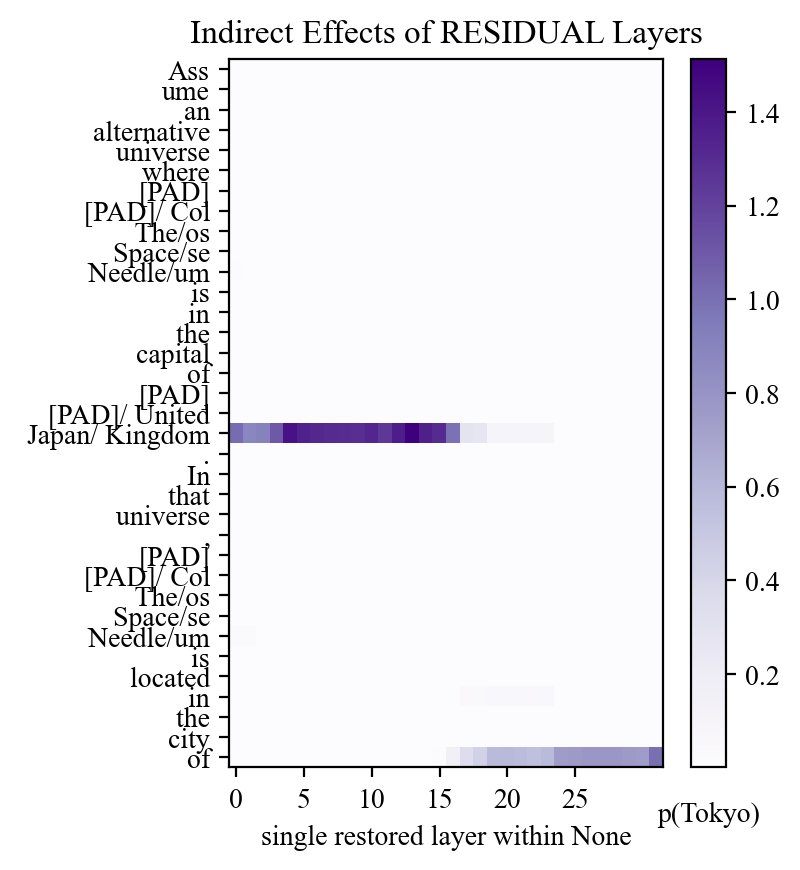

In [43]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(indirect_effects)

2024-06-22 16:45:11 src.trace DEBUG    idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
2024-06-22 16:45:11 src.trace DEBUG    idx=1 =>  [1] Ass || [1] Ass
2024-06-22 16:45:11 src.trace DEBUG    idx=2 =>  [1] ume || [1] ume
2024-06-22 16:45:11 src.trace DEBUG    idx=3 =>  [1]  an || [1]  an
2024-06-22 16:45:11 src.trace DEBUG    idx=4 =>  [1]  alternative || [1]  alternative
2024-06-22 16:45:11 src.trace DEBUG    idx=5 =>  [1]  universe || [1]  universe
2024-06-22 16:45:11 src.trace DEBUG    idx=6 =>  [1]  where || [1]  where
2024-06-22 16:45:11 src.trace DEBUG    idx=7 =>  [0] <|end_of_text|> || [0] <|end_of_text|>
2024-06-22 16:45:11 src.trace DEBUG    idx=8 =>  [0] <|end_of_text|> || [1]  Col
2024-06-22 16:45:11 src.trace DEBUG    idx=9 =>  [1]  The || [1] os
2024-06-22 16:45:11 src.trace DEBUG    idx=10 =>  [1]  Space || [1] se
2024-06-22 16:45:11 src.trace DEBUG    idx=11 =>  [1]  Needle || [1] um
2024-06-22 16:45:11 src.trace DEBUG    idx=12 =>  [1]  is || [1]  is
2024-06

2024-06-22 16:45:12 src.trace DEBUG    answer=PredictedToken(token=' Tokyo', prob=0.31478607654571533, token_id=tensor(27286, device='cuda:0'))
2024-06-22 16:45:12 src.trace DEBUG    corrupt_answer=PredictedToken(token=' London', prob=0.6509705781936646, token_id=tensor(7295, device='cuda:0'))
2024-06-22 16:45:12 src.trace DEBUG    track_ans=[(184, PredictedToken(token=' Tokyo', prob=0.00020514556672424078, token_id=27286))]
2024-06-22 16:45:12 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 1120/1120 [00:39<00:00, 28.30it/s]

2024-06-22 16:45:52 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd326f0ed90>
2024-06-22 16:45:52 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:45:52 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2024-06-22 16:45:52 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:45:52 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


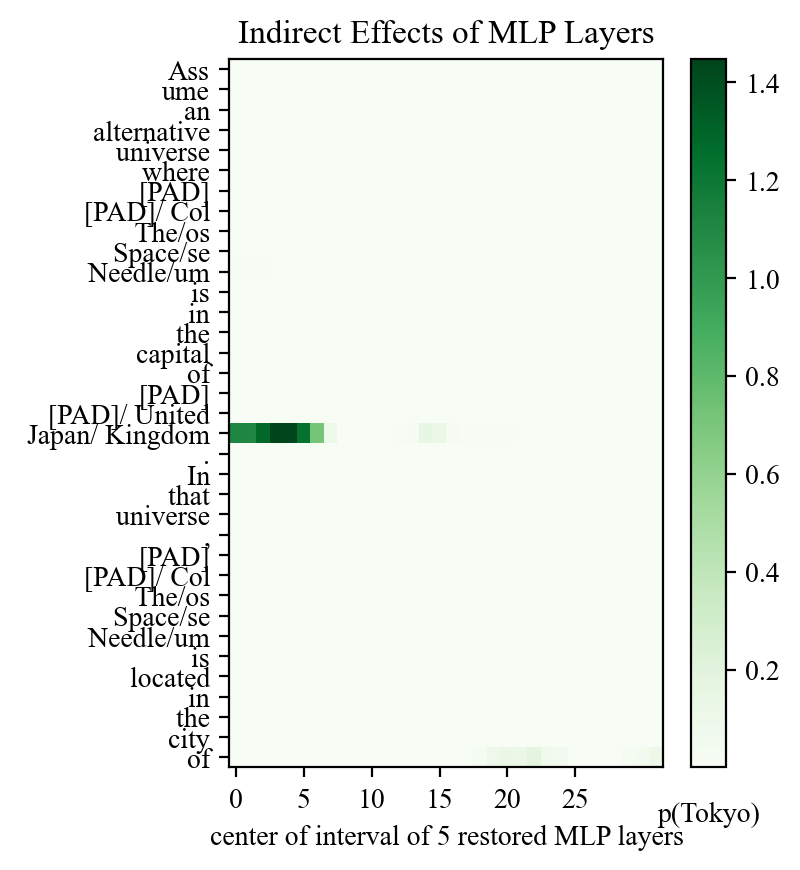

In [44]:
indirect_effects_mlp = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrupt_query,
    kind="mlp",
    normalize=True,
    trace_token_strategy="all",
    window_size=5
)

plot_trace_heatmap(indirect_effects_mlp)

2024-06-22 16:45:52 src.trace DEBUG    idx=0 =>  [1] <|begin_of_text|> || [1] <|begin_of_text|>
2024-06-22 16:45:52 src.trace DEBUG    idx=1 =>  [1] Ass || [1] Ass
2024-06-22 16:45:52 src.trace DEBUG    idx=2 =>  [1] ume || [1] ume
2024-06-22 16:45:52 src.trace DEBUG    idx=3 =>  [1]  an || [1]  an
2024-06-22 16:45:52 src.trace DEBUG    idx=4 =>  [1]  alternative || [1]  alternative
2024-06-22 16:45:52 src.trace DEBUG    idx=5 =>  [1]  universe || [1]  universe
2024-06-22 16:45:52 src.trace DEBUG    idx=6 =>  [1]  where || [1]  where
2024-06-22 16:45:52 src.trace DEBUG    idx=7 =>  [0] <|end_of_text|> || [0] <|end_of_text|>
2024-06-22 16:45:52 src.trace DEBUG    idx=8 =>  [0] <|end_of_text|> || [1]  Col
2024-06-22 16:45:52 src.trace DEBUG    idx=9 =>  [1]  The || [1] os
2024-06-22 16:45:52 src.trace DEBUG    idx=10 =>  [1]  Space || [1] se
2024-06-22 16:45:52 src.trace DEBUG    idx=11 =>  [1]  Needle || [1] um
2024-06-22 16:45:52 src.trace DEBUG    idx=12 =>  [1]  is || [1]  is
2024-06

2024-06-22 16:45:53 src.trace DEBUG    answer=PredictedToken(token=' Tokyo', prob=0.31478607654571533, token_id=tensor(27286, device='cuda:0'))
2024-06-22 16:45:53 src.trace DEBUG    corrupt_answer=PredictedToken(token=' London', prob=0.6509705781936646, token_id=tensor(7295, device='cuda:0'))
2024-06-22 16:45:53 src.trace DEBUG    track_ans=[(184, PredictedToken(token=' Tokyo', prob=0.00020514556672424078, token_id=27286))]
2024-06-22 16:45:53 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 1120/1120 [00:42<00:00, 26.63it/s]

2024-06-22 16:46:35 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd326c4a250>
2024-06-22 16:46:35 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:46:35 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2024-06-22 16:46:35 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-06-22 16:46:35 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


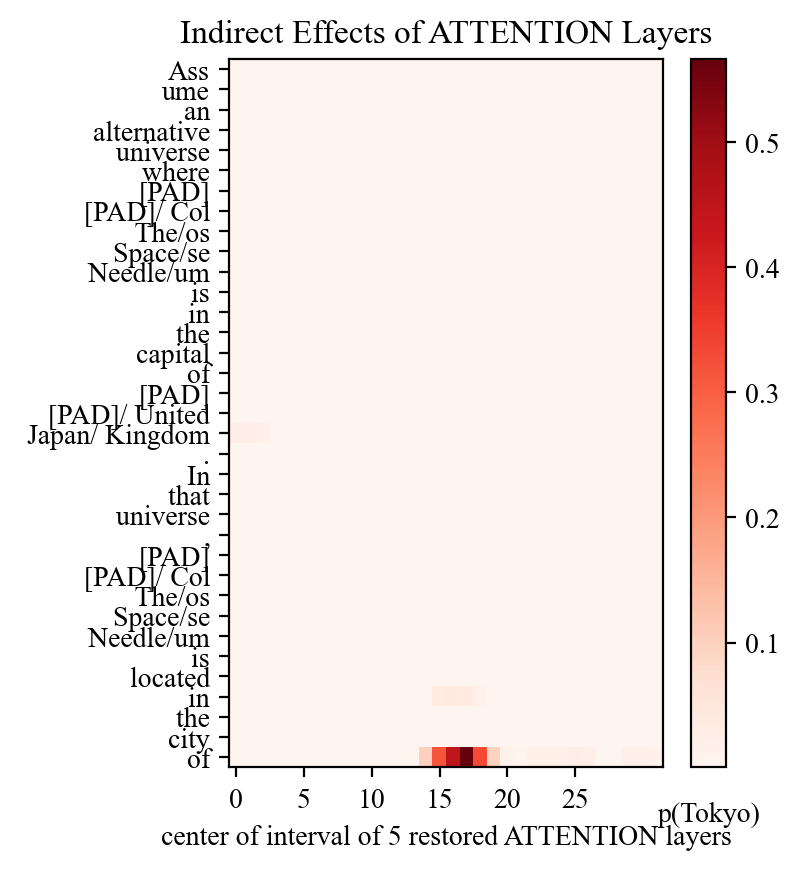

In [45]:
indirect_effects_attn = trace_important_states(
    mt=mt, 
    clean_query=clean_query,
    corrupt_query=corrupt_query,
    kind="attention",
    normalize=True,
    trace_token_strategy="all",
    window_size=5
)

plot_trace_heatmap(indirect_effects_attn)